**Q3 - 1.1**

Using cuda:0 device


  0%|          | 0/3 [00:00<?, ?it/s]

Processing Reviews: 100%|██████████| 25000/25000 [00:05<00:00, 4639.87it/s]


RNNModel(
  (embedding): Embedding(58278, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 191.55it/s]


Epoch 1/5, Train Loss: 0.7120, Val Loss: 0.6935, Val Accuracy: 0.5157


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 195.64it/s]


Epoch 2/5, Train Loss: 0.7029, Val Loss: 0.6973, Val Accuracy: 0.5155


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 187.38it/s]


Epoch 3/5, Train Loss: 0.7060, Val Loss: 0.7138, Val Accuracy: 0.5157


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 188.96it/s]


Epoch 4/5, Train Loss: 0.7001, Val Loss: 0.6957, Val Accuracy: 0.4840


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 191.77it/s]


Epoch 5/5, Train Loss: 0.7012, Val Loss: 0.6929, Val Accuracy: 0.5165


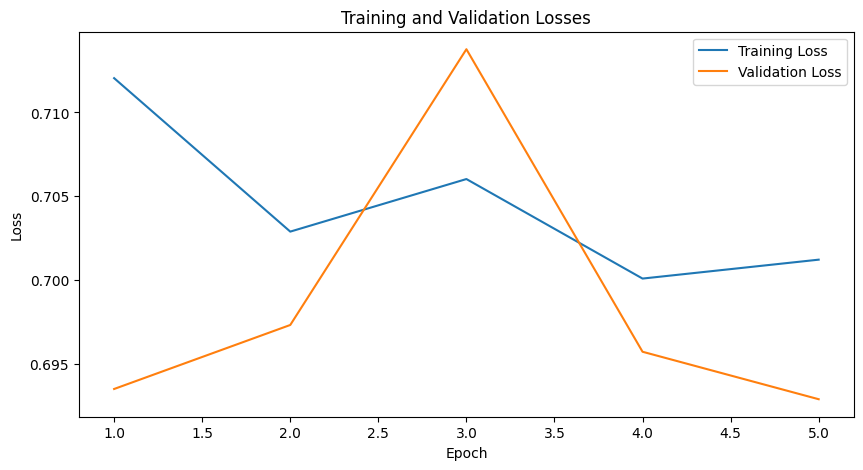

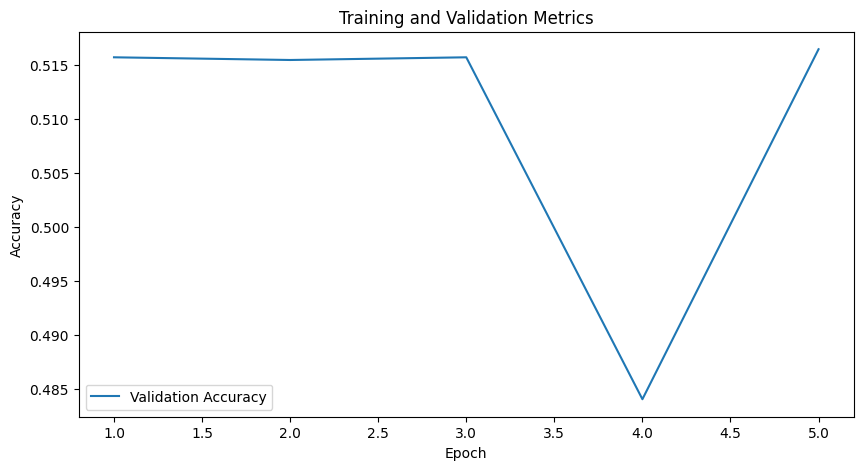

Evaluating Model: 100%|██████████| 628/628 [00:02<00:00, 226.41it/s]

Classification Accuracy on Test Set: 0.5096


In [18]:
!pip install datasets torchmetrics

import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from torch.utils.data import random_split

from sklearn.model_selection import train_test_split

from collections import defaultdict

from tqdm import tqdm


SEED = 1234
# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

# Extract features and labels from the dataset
features = imdb_dataset['train']['text']
labels = imdb_dataset['train']['label']

# Split the data into train and validation sets while maintaining label ratios
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)


def clean(text, tokenizer):
    text = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens
    
    
def get_word2idx(reviews):
    idx = 1
    word2idx = defaultdict(int)
    for sentence in tqdm(reviews, total=len(reviews), desc="Creating word2idx"):
        # Clean and tokenize the sentence
        words = clean(sentence, RegexpTokenizer(r'\w+'))
        
        # Check if sentence length is within the specified range
        if (len(words) <= 500) and (len(words) >= 100):
            for word in words:
                # Check if word is not already in word2idx
                if word not in word2idx:
                    word2idx[word] = idx
                    idx += 1

    return idx, word2idx

idx, word2idx = get_word2idx(train_reviews);
    
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean(review, tokenizer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]
    

test_reviews = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']
train_ds = IMDBDataset(train_reviews, train_labels, word2idx, minlen=100, maxlen=500)
val_ds = IMDBDataset(val_reviews, val_labels, word2idx, minlen=100, maxlen=500)
test_ds = IMDBDataset(test_reviews, test_labels, word2idx, minlen=100, maxlen=500)

# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
test_dataloader = DataLoader(test_ds, **params)
val_dataloader = DataLoader(val_ds, **params)


class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)  # Apply embedding
        _, rnn_output = self.rnn(embedded)  # RNN layer
        logits = self.fc(rnn_output.squeeze(0))  # Take the last time step output for classification
        return logits
    
    
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2
vocab_size = len(word2idx)+1

# Create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary
print(model)


def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    val_accuracy = []  # List to store validation accuracy

    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training Epoch {}".format(epoch + 1)):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()  # Clear gradients
            output = model(input_batch)  # Forward pass
            loss = criterion(output, output_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            train_loss += loss.item() * input_batch.size(0)  # Accumulate training loss

        train_loss /= len(train_dataloader.dataset)  # Calculate average training loss
        train_losses.append(train_loss)  # Save training loss for this epoch

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation Epoch {}".format(epoch + 1)):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                output = model(input_batch)  # Forward pass
                loss = criterion(output, output_batch)  # Compute validation loss
                val_loss += loss.item() * input_batch.size(0)  # Accumulate validation loss

                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct_preds += (predicted == output_batch).sum().item()
                total_preds += output_batch.size(0)

        val_loss /= len(val_dataloader.dataset)  # Calculate average validation loss
        val_losses.append(val_loss)  # Save validation loss for this epoch

        accuracy = correct_preds / total_preds  # Calculate validation accuracy
        val_accuracy.append(accuracy)  # Save validation accuracy for this epoch

        # Log metrics
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model_state)

    return train_losses, val_losses, val_accuracy

#Calling model here
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, 5, device)


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(dataloader, total=len(dataloader), desc="Evaluating Model"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            output = model(input_batch)  # Forward pass
            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == output_batch).sum().item()
            total_preds += output_batch.size(0)
    
    accuracy = correct_preds / total_preds
    return accuracy

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, test_dataloader)

print(f"Classification Accuracy on Test Set: {test_accuracy:.4f}")

**Q3 - 1.2 Stemming**

Using cuda:0 device


  0%|          | 0/3 [00:00<?, ?it/s]

Processing Reviews: 100%|██████████| 25000/25000 [02:44<00:00, 151.61it/s]


RNNModel(
  (embedding): Embedding(40435, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 185.79it/s]


Epoch 1/5, Train Loss: 0.6987, Val Loss: 0.6979, Val Accuracy: 0.4840


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 182.59it/s]


Epoch 2/5, Train Loss: 0.7076, Val Loss: 0.7023, Val Accuracy: 0.4835


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 193.49it/s]


Epoch 3/5, Train Loss: 0.6997, Val Loss: 0.6967, Val Accuracy: 0.5165


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 198.97it/s]


Epoch 4/5, Train Loss: 0.6998, Val Loss: 0.6948, Val Accuracy: 0.5155


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 192.63it/s]


Epoch 5/5, Train Loss: 0.7017, Val Loss: 0.6927, Val Accuracy: 0.5157


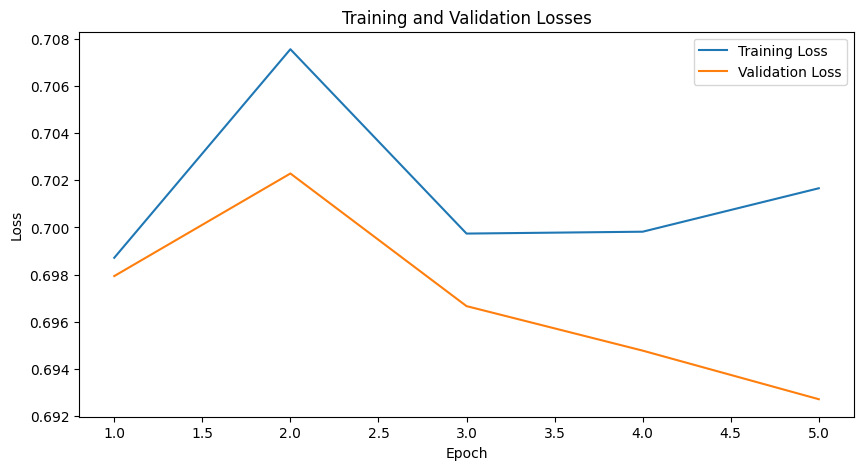

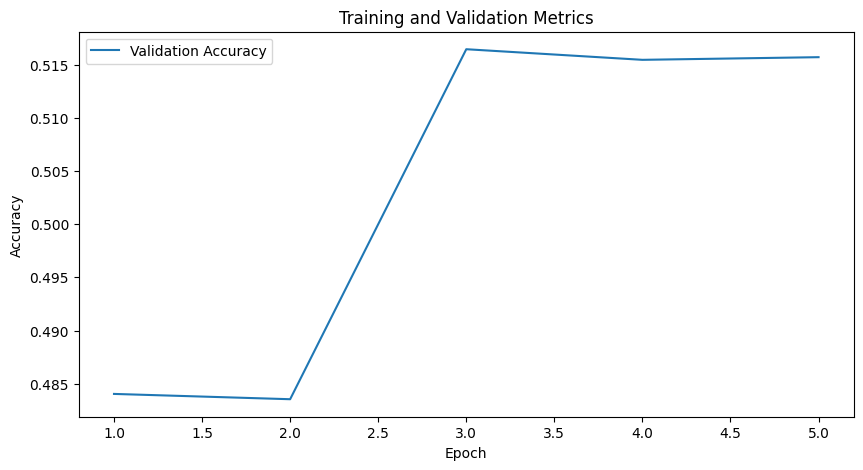

Evaluating Model: 100%|██████████| 628/628 [00:02<00:00, 224.71it/s]

Classification Accuracy on Test Set: 0.5093


In [19]:
!pip install datasets torchmetrics

import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer

import nltk
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from torch.utils.data import random_split

from sklearn.model_selection import train_test_split

from collections import defaultdict

from tqdm import tqdm


SEED = 1234
# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

# Extract features and labels from the dataset
features = imdb_dataset['train']['text']
labels = imdb_dataset['train']['label']

# Split the data into train and validation sets while maintaining label ratios
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)


def clean(text, tokenizer, stemmer):
    itext = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens
    
def get_word2idx(reviews):
    idx = 1
    word2idx = defaultdict(int)
    for sentence in tqdm(reviews, total=len(reviews), desc="Creating word2idx"):
        # Clean and tokenize the sentence
        words = clean(sentence, RegexpTokenizer(r'\w+'), stemmer)
        
        # Check if sentence length is within the specified range
        if (len(words) <= 500) and (len(words) >= 100):
            for word in words:
                # Check if word is not already in word2idx
                if word not in word2idx:
                    word2idx[word] = idx
                    idx += 1

    return idx, word2idx

idx, word2idx = get_word2idx(train_reviews);
    
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean(review, tokenizer, stemmer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]
    

test_reviews = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']
train_ds = IMDBDataset(train_reviews, train_labels, word2idx, minlen=100, maxlen=500)
val_ds = IMDBDataset(val_reviews, val_labels, word2idx, minlen=100, maxlen=500)
test_ds = IMDBDataset(test_reviews, test_labels, word2idx, minlen=100, maxlen=500)

# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
test_dataloader = DataLoader(test_ds, **params)
val_dataloader = DataLoader(val_ds, **params)


class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)  # Apply embedding
        _, rnn_output = self.rnn(embedded)  # RNN layer
        logits = self.fc(rnn_output.squeeze(0))  # Take the last time step output for classification
        return logits
    
    
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2
vocab_size = len(word2idx)+1

# Create the model
model = RNNModel(len(word2idx)+1, hidden_size, embedding_dim, num_classes).to(device)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary
print(model)


def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    val_accuracy = []  # List to store validation accuracy

    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training Epoch {}".format(epoch + 1)):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()  # Clear gradients
            output = model(input_batch)  # Forward pass
            loss = criterion(output, output_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            train_loss += loss.item() * input_batch.size(0)  # Accumulate training loss

        train_loss /= len(train_dataloader.dataset)  # Calculate average training loss
        train_losses.append(train_loss)  # Save training loss for this epoch

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation Epoch {}".format(epoch + 1)):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                output = model(input_batch)  # Forward pass
                loss = criterion(output, output_batch)  # Compute validation loss
                val_loss += loss.item() * input_batch.size(0)  # Accumulate validation loss

                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct_preds += (predicted == output_batch).sum().item()
                total_preds += output_batch.size(0)

        val_loss /= len(val_dataloader.dataset)  # Calculate average validation loss
        val_losses.append(val_loss)  # Save validation loss for this epoch

        accuracy = correct_preds / total_preds  # Calculate validation accuracy
        val_accuracy.append(accuracy)  # Save validation accuracy for this epoch

        # Log metrics
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model_state)

    return train_losses, val_losses, val_accuracy

#Calling model here
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, 5, device)


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(dataloader, total=len(dataloader), desc="Evaluating Model"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            output = model(input_batch)  # Forward pass
            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == output_batch).sum().item()
            total_preds += output_batch.size(0)
    
    accuracy = correct_preds / total_preds
    return accuracy

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, test_dataloader)

print(f"Classification Accuracy on Test Set: {test_accuracy:.4f}")

*Overall, the difference in accuracy between using stemming and not using stemming is very small (0.5096 vs. 0.5093), indicating that stemming did not have a substantial impact on the model's ability to classify sentiment in this context. It's important to note that the effectiveness of stemming can vary depending on factors such as the nature of the dataset, the specific task, and the characteristics of the text data being processed.*

**Q3 - 1.3 Picking last output**

Using cuda:0 device


  0%|          | 0/3 [00:00<?, ?it/s]

Processing Reviews: 100%|██████████| 25000/25000 [00:05<00:00, 4622.16it/s]


RNNModel(
  (embedding): Embedding(58278, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 200.46it/s]


Epoch 1/5, Train Loss: 0.7120, Val Loss: 0.6935, Val Accuracy: 0.5157


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 195.36it/s]


Epoch 2/5, Train Loss: 0.7029, Val Loss: 0.6973, Val Accuracy: 0.5155


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 198.38it/s]


Epoch 3/5, Train Loss: 0.7060, Val Loss: 0.7138, Val Accuracy: 0.5157


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 193.62it/s]


Epoch 4/5, Train Loss: 0.7001, Val Loss: 0.6957, Val Accuracy: 0.4840


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 187.52it/s]


Epoch 5/5, Train Loss: 0.7012, Val Loss: 0.6929, Val Accuracy: 0.5165


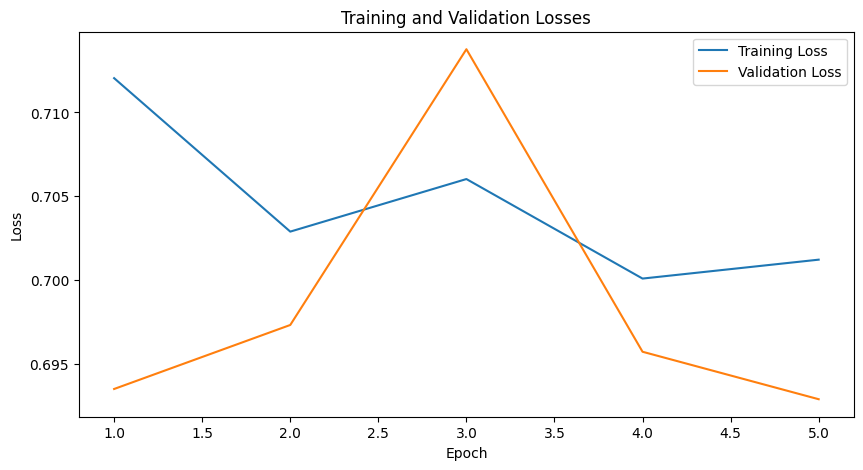

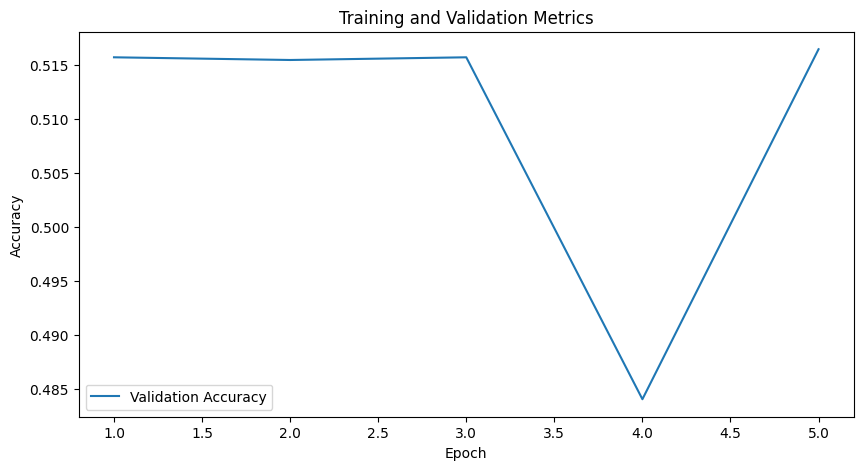

Evaluating Model: 100%|██████████| 628/628 [00:02<00:00, 224.71it/s]

Classification Accuracy on Test Set: 0.5096


In [20]:
!pip install datasets torchmetrics

import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from torch.utils.data import random_split

from sklearn.model_selection import train_test_split

from collections import defaultdict

from tqdm import tqdm


SEED = 1234
# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

# Extract features and labels from the dataset
features = imdb_dataset['train']['text']
labels = imdb_dataset['train']['label']

# Split the data into train and validation sets while maintaining label ratios
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)


def clean(text, tokenizer):
    text = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens
    
    
def get_word2idx(reviews):
    idx = 1
    word2idx = defaultdict(int)
    for sentence in tqdm(reviews, total=len(reviews), desc="Creating word2idx"):
        # Clean and tokenize the sentence
        words = clean(sentence, RegexpTokenizer(r'\w+'))
        
        # Check if sentence length is within the specified range
        if (len(words) <= 500) and (len(words) >= 100):
            for word in words:
                # Check if word is not already in word2idx
                if word not in word2idx:
                    word2idx[word] = idx
                    idx += 1

    return idx, word2idx

idx, word2idx = get_word2idx(train_reviews);
    
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean(review, tokenizer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]
    

test_reviews = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']
train_ds = IMDBDataset(train_reviews, train_labels, word2idx, minlen=100, maxlen=500)
val_ds = IMDBDataset(val_reviews, val_labels, word2idx, minlen=100, maxlen=500)
test_ds = IMDBDataset(test_reviews, test_labels, word2idx, minlen=100, maxlen=500)

# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
test_dataloader = DataLoader(test_ds, **params)
val_dataloader = DataLoader(val_ds, **params)


class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)  # Apply embedding
        rnn_output, _ = self.rnn(embedded)  # RNN layer
        last_output = rnn_output[:, -1, :]  # Take the last time step output for classification
        logits = self.fc(last_output)  # Apply linear layer
        return logits
    
    
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2
vocab_size = len(word2idx)+1

# Create the model
model = RNNModel(len(word2idx)+1, hidden_size, embedding_dim, num_classes).to(device)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary
print(model)


def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    val_accuracy = []  # List to store validation accuracy

    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training Epoch {}".format(epoch + 1)):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()  # Clear gradients
            output = model(input_batch)  # Forward pass
            loss = criterion(output, output_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            train_loss += loss.item() * input_batch.size(0)  # Accumulate training loss

        train_loss /= len(train_dataloader.dataset)  # Calculate average training loss
        train_losses.append(train_loss)  # Save training loss for this epoch

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation Epoch {}".format(epoch + 1)):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                output = model(input_batch)  # Forward pass
                loss = criterion(output, output_batch)  # Compute validation loss
                val_loss += loss.item() * input_batch.size(0)  # Accumulate validation loss

                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct_preds += (predicted == output_batch).sum().item()
                total_preds += output_batch.size(0)

        val_loss /= len(val_dataloader.dataset)  # Calculate average validation loss
        val_losses.append(val_loss)  # Save validation loss for this epoch

        accuracy = correct_preds / total_preds  # Calculate validation accuracy
        val_accuracy.append(accuracy)  # Save validation accuracy for this epoch

        # Log metrics
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model_state)

    return train_losses, val_losses, val_accuracy

#Calling model here
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, 5, device)


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(dataloader, total=len(dataloader), desc="Evaluating Model"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            output = model(input_batch)  # Forward pass
            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == output_batch).sum().item()
            total_preds += output_batch.size(0)
    
    accuracy = correct_preds / total_preds
    return accuracy

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, test_dataloader)

print(f"Classification Accuracy on Test Set: {test_accuracy:.4f}")

**Q3 - 1.3 Mean of all output**

Using cuda:0 device


  0%|          | 0/3 [00:00<?, ?it/s]

Processing Reviews: 100%|██████████| 25000/25000 [00:05<00:00, 4635.00it/s]


RNNModel(
  (embedding): Embedding(58278, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 187.16it/s]


Epoch 1/5, Train Loss: 0.6880, Val Loss: 0.6839, Val Accuracy: 0.5466


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 191.57it/s]


Epoch 2/5, Train Loss: 0.5869, Val Loss: 0.4620, Val Accuracy: 0.7833


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 192.45it/s]


Epoch 3/5, Train Loss: 0.3376, Val Loss: 0.3676, Val Accuracy: 0.8466


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 188.68it/s]


Epoch 4/5, Train Loss: 0.2445, Val Loss: 0.3990, Val Accuracy: 0.8454


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 191.62it/s]


Epoch 5/5, Train Loss: 0.2598, Val Loss: 0.3283, Val Accuracy: 0.8676


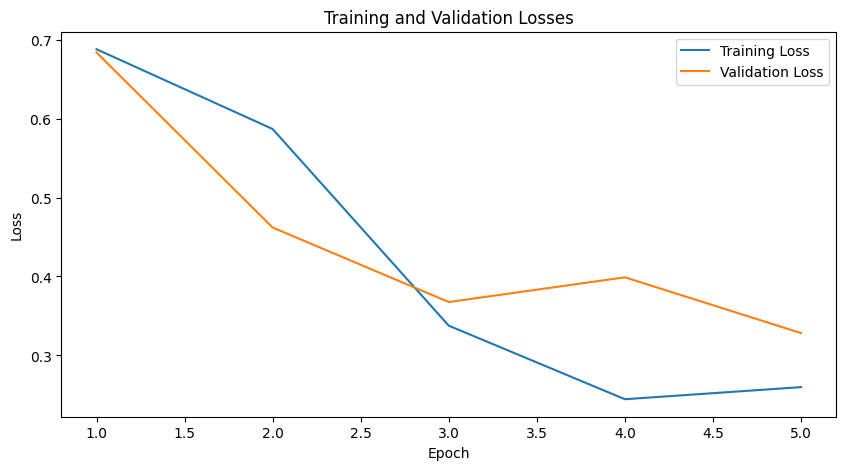

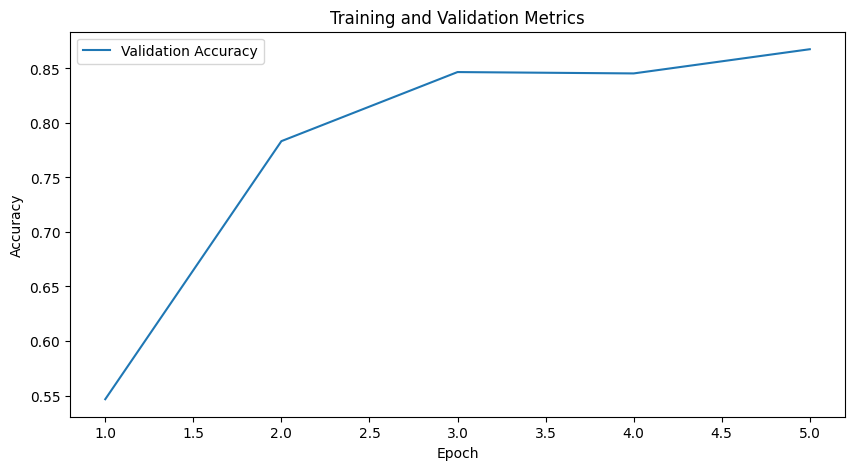

Evaluating Model: 100%|██████████| 628/628 [00:02<00:00, 217.41it/s]

Classification Accuracy on Test Set: 0.8475


In [21]:
!pip install datasets torchmetrics

import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from torch.utils.data import random_split

from sklearn.model_selection import train_test_split

from collections import defaultdict

from tqdm import tqdm


SEED = 1234
# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

# Extract features and labels from the dataset
features = imdb_dataset['train']['text']
labels = imdb_dataset['train']['label']

# Split the data into train and validation sets while maintaining label ratios
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)


def clean(text, tokenizer):
    text = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens
    
    
def get_word2idx(reviews):
    idx = 1
    word2idx = defaultdict(int)
    for sentence in tqdm(reviews, total=len(reviews), desc="Creating word2idx"):
        # Clean and tokenize the sentence
        words = clean(sentence, RegexpTokenizer(r'\w+'))
        
        # Check if sentence length is within the specified range
        if (len(words) <= 500) and (len(words) >= 100):
            for word in words:
                # Check if word is not already in word2idx
                if word not in word2idx:
                    word2idx[word] = idx
                    idx += 1

    return idx, word2idx

idx, word2idx = get_word2idx(train_reviews);
    
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean(review, tokenizer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]
    

test_reviews = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']
train_ds = IMDBDataset(train_reviews, train_labels, word2idx, minlen=100, maxlen=500)
val_ds = IMDBDataset(val_reviews, val_labels, word2idx, minlen=100, maxlen=500)
test_ds = IMDBDataset(test_reviews, test_labels, word2idx, minlen=100, maxlen=500)

# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
test_dataloader = DataLoader(test_ds, **params)
val_dataloader = DataLoader(val_ds, **params)


class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)  # Apply embedding
        rnn_output, _ = self.rnn(embedded)  # RNN layer
        mean_output = torch.mean(rnn_output, dim=1)  # Take the mean of all time steps' outputs
        logits = self.fc(mean_output)  # Apply linear layer
        return logits
    
    
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2
vocab_size = len(word2idx)+1

# Create the model
model = RNNModel(len(word2idx)+1, hidden_size, embedding_dim, num_classes).to(device)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary
print(model)


def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    val_accuracy = []  # List to store validation accuracy

    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training Epoch {}".format(epoch + 1)):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()  # Clear gradients
            output = model(input_batch)  # Forward pass
            loss = criterion(output, output_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            train_loss += loss.item() * input_batch.size(0)  # Accumulate training loss

        train_loss /= len(train_dataloader.dataset)  # Calculate average training loss
        train_losses.append(train_loss)  # Save training loss for this epoch

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation Epoch {}".format(epoch + 1)):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                output = model(input_batch)  # Forward pass
                loss = criterion(output, output_batch)  # Compute validation loss
                val_loss += loss.item() * input_batch.size(0)  # Accumulate validation loss

                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct_preds += (predicted == output_batch).sum().item()
                total_preds += output_batch.size(0)

        val_loss /= len(val_dataloader.dataset)  # Calculate average validation loss
        val_losses.append(val_loss)  # Save validation loss for this epoch

        accuracy = correct_preds / total_preds  # Calculate validation accuracy
        val_accuracy.append(accuracy)  # Save validation accuracy for this epoch

        # Log metrics
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model_state)

    return train_losses, val_losses, val_accuracy

#Calling model here
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, 5, device)


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(dataloader, total=len(dataloader), desc="Evaluating Model"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            output = model(input_batch)  # Forward pass
            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == output_batch).sum().item()
            total_preds += output_batch.size(0)
    
    accuracy = correct_preds / total_preds
    return accuracy

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, test_dataloader)

print(f"Classification Accuracy on Test Set: {test_accuracy:.4f}")

*The changes observed in accuracy between picking the last output and taking the mean of all outputs in an RNN model can be significant and are usually influenced by the nature of the task and the characteristics of the data. Here's what the observed changes indicate:

Picking the last output (accuracy = 0.5096): This approach involves using only the final output of the RNN sequence, which may not capture the complete information or context of the input sequence. The accuracy achieved with this method (0.5096) suggests that relying solely on the last output for classification leads to suboptimal performance. The model may struggle to capture long-term dependencies and nuances in the input data, resulting in lower accuracy.

Taking the mean of all outputs (accuracy = 0.8475): On the other hand, averaging all outputs of the RNN sequence allows the model to incorporate information from all time steps, providing a more comprehensive understanding of the input sequence. This approach can be beneficial for tasks where the entire input sequence is relevant for making predictions or classifications. The significant increase in accuracy (from 0.5096 to 0.8475) indicates that leveraging information from all time steps leads to a much-improved model performance.

Overall, the observed changes highlight the importance of considering temporal dependencies and utilizing information from multiple time steps in sequential data tasks. Averaging all outputs or using mechanisms like attention mechanisms to weigh different time steps can enhance the model's ability to capture relevant patterns and context, leading to better predictive accuracy.*

**Q3 - 2**

In [8]:
!pip install datasets torchmetrics

import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from torch.utils.data import random_split

from sklearn.model_selection import train_test_split

from collections import defaultdict

from tqdm import tqdm


SEED = 1234
# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

# Extract features and labels from the dataset
features = imdb_dataset['train']['text']
labels = imdb_dataset['train']['label']

# Split the data into train and validation sets while maintaining label ratios
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)


def clean(text, tokenizer):
    text = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens
    
    
def get_word2idx(reviews):
    idx = 1
    word2idx = defaultdict(int)
    for sentence in tqdm(reviews, total=len(reviews), desc="Creating word2idx"):
        # Clean and tokenize the sentence
        words = clean(sentence, RegexpTokenizer(r'\w+'))
        
        # Check if sentence length is within the specified range
        if (len(words) <= 500) and (len(words) >= 100):
            for word in words:
                # Check if word is not already in word2idx
                if word not in word2idx:
                    word2idx[word] = idx
                    idx += 1

    return idx, word2idx

idx, word2idx = get_word2idx(train_reviews);
    
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean(review, tokenizer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]
    

test_reviews = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']
train_ds = IMDBDataset(train_reviews, train_labels, word2idx, minlen=100, maxlen=500)
val_ds = IMDBDataset(val_reviews, val_labels, word2idx, minlen=100, maxlen=500)
test_ds = IMDBDataset(test_reviews, test_labels, word2idx, minlen=100, maxlen=500)

# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
test_dataloader = DataLoader(test_ds, **params)
val_dataloader = DataLoader(val_ds, **params)


class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)  # Apply embedding
        rnn_output, _ = self.rnn(embedded)  # RNN layer
        mean_output = torch.mean(rnn_output, dim=1)  # Take the mean of all time steps' outputs
        logits = self.fc(mean_output)  # Apply linear layer
        return logits


def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    val_accuracy = []  # List to store validation accuracy

    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training Epoch {}".format(epoch + 1)):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()  # Clear gradients
            output = model(input_batch)  # Forward pass
            loss = criterion(output, output_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            train_loss += loss.item() * input_batch.size(0)  # Accumulate training loss

        train_loss /= len(train_dataloader.dataset)  # Calculate average training loss
        train_losses.append(train_loss)  # Save training loss for this epoch

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation Epoch {}".format(epoch + 1)):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                output = model(input_batch)  # Forward pass
                loss = criterion(output, output_batch)  # Compute validation loss
                val_loss += loss.item() * input_batch.size(0)  # Accumulate validation loss

                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct_preds += (predicted == output_batch).sum().item()
                total_preds += output_batch.size(0)

        val_loss /= len(val_dataloader.dataset)  # Calculate average validation loss
        val_losses.append(val_loss)  # Save validation loss for this epoch

        accuracy = correct_preds / total_preds  # Calculate validation accuracy
        val_accuracy.append(accuracy)  # Save validation accuracy for this epoch

        # Log metrics
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model_state)

    return train_losses, val_losses, val_accuracy

def evaluate_model(model, dataloader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(dataloader, total=len(dataloader), desc="Evaluating Model"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            output = model(input_batch)  # Forward pass
            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == output_batch).sum().item()
            total_preds += output_batch.size(0)
    
    accuracy = correct_preds / total_preds
    return accuracy


# hyperparameter configurations to experiment with
hyperparameters = [
    {'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 32},
    {'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 64},
    {'embedding_dim': 64, 'hidden_size': 128, 'batch_size': 16},
    {'embedding_dim': 128, 'hidden_size': 512, 'batch_size': 32},
    {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64}
]

best_classification_accuracy = 0.0
best_model = None
best_params = None

learning_rate = 1e-3

# Loop through each hyperparameter configuration and train the model
for idx, params in enumerate(hyperparameters):
    print(f"Training Model with Hyperparameters Configuration {idx + 1}: {params}")
    
    # Update model hyperparameters
    embedding_dim = params['embedding_dim']
    hidden_size = params['hidden_size']
    batch_size = params['batch_size']

    # Create the model
    model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

    # Define the criterion (loss function)
    criterion = nn.CrossEntropyLoss()

    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader with updated batch size
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    # Train the model
    train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs, device)

    # Evaluate the model on the test set
    test_classification_accuracy = evaluate_model(model, test_dataloader)

    # Print results
    print(f"Classification Accuracy on Test Set: {test_classification_accuracy:.4f}")
    print("")

    # Check if current model is the best model based on validation accuracy
    if test_classification_accuracy > best_classification_accuracy:
        best_classification_accuracy = test_classification_accuracy
        best_model = model
        best_params = params
        

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_classification_accuracy:.4f}")

Using cuda:0 device


  0%|          | 0/3 [00:00<?, ?it/s]

Processing Reviews: 100%|██████████| 25000/25000 [00:05<00:00, 4421.72it/s]


Training Model with Hyperparameters Configuration 1: {'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 32}


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 185.29it/s]


Epoch 1/5, Train Loss: 0.6880, Val Loss: 0.6839, Val Accuracy: 0.5466


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 181.65it/s]


Epoch 2/5, Train Loss: 0.6374, Val Loss: 0.5698, Val Accuracy: 0.7549


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 190.53it/s]


Epoch 3/5, Train Loss: 0.3868, Val Loss: 0.3769, Val Accuracy: 0.8399


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 188.57it/s]


Epoch 4/5, Train Loss: 0.2501, Val Loss: 0.3366, Val Accuracy: 0.8613


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 186.79it/s]


Epoch 5/5, Train Loss: 0.2416, Val Loss: 0.5397, Val Accuracy: 0.8007


Evaluating Model: 100%|██████████| 628/628 [00:02<00:00, 221.56it/s]


Classification Accuracy on Test Set: 0.7839

Training Model with Hyperparameters Configuration 2: {'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 64}


Validation Epoch 1: 100%|██████████| 63/63 [00:01<00:00, 54.25it/s]


Epoch 1/5, Train Loss: 0.6643, Val Loss: 0.6083, Val Accuracy: 0.7259


Validation Epoch 2: 100%|██████████| 63/63 [00:01<00:00, 54.15it/s]


Epoch 2/5, Train Loss: 0.5341, Val Loss: 0.5313, Val Accuracy: 0.7905


Validation Epoch 3: 100%|██████████| 63/63 [00:01<00:00, 55.64it/s]


Epoch 3/5, Train Loss: 0.5764, Val Loss: 0.6966, Val Accuracy: 0.5082


Validation Epoch 4: 100%|██████████| 63/63 [00:01<00:00, 54.48it/s]


Epoch 4/5, Train Loss: 0.6862, Val Loss: 0.7269, Val Accuracy: 0.5135


Validation Epoch 5: 100%|██████████| 63/63 [00:01<00:00, 54.48it/s]


Epoch 5/5, Train Loss: 0.6490, Val Loss: 0.6656, Val Accuracy: 0.5713


Evaluating Model: 100%|██████████| 314/314 [00:05<00:00, 59.08it/s]


Classification Accuracy on Test Set: 0.5747

Training Model with Hyperparameters Configuration 3: {'embedding_dim': 64, 'hidden_size': 128, 'batch_size': 16}


Validation Epoch 1: 100%|██████████| 251/251 [00:00<00:00, 290.37it/s]


Epoch 1/5, Train Loss: 0.6610, Val Loss: 0.6850, Val Accuracy: 0.5658


Validation Epoch 2: 100%|██████████| 251/251 [00:00<00:00, 305.63it/s]


Epoch 2/5, Train Loss: 0.5089, Val Loss: 0.4035, Val Accuracy: 0.8272


Validation Epoch 3: 100%|██████████| 251/251 [00:00<00:00, 251.52it/s]


Epoch 3/5, Train Loss: 0.3025, Val Loss: 0.3445, Val Accuracy: 0.8544


Validation Epoch 4: 100%|██████████| 251/251 [00:00<00:00, 293.32it/s]


Epoch 4/5, Train Loss: 0.2239, Val Loss: 0.3446, Val Accuracy: 0.8586


Validation Epoch 5: 100%|██████████| 251/251 [00:00<00:00, 299.36it/s]


Epoch 5/5, Train Loss: 0.1561, Val Loss: 0.4186, Val Accuracy: 0.8524


Evaluating Model: 100%|██████████| 1255/1255 [00:04<00:00, 301.74it/s]


Classification Accuracy on Test Set: 0.8345

Training Model with Hyperparameters Configuration 4: {'embedding_dim': 128, 'hidden_size': 512, 'batch_size': 32}


Validation Epoch 1: 100%|██████████| 126/126 [00:01<00:00, 80.98it/s]


Epoch 1/5, Train Loss: 0.7079, Val Loss: 0.6940, Val Accuracy: 0.4878


Validation Epoch 2: 100%|██████████| 126/126 [00:01<00:00, 80.92it/s]


Epoch 2/5, Train Loss: 0.7075, Val Loss: 0.6923, Val Accuracy: 0.4978


Validation Epoch 3: 100%|██████████| 126/126 [00:01<00:00, 82.14it/s]


Epoch 3/5, Train Loss: 0.6695, Val Loss: 0.6194, Val Accuracy: 0.6506


Validation Epoch 4: 100%|██████████| 126/126 [00:01<00:00, 81.52it/s]


Epoch 4/5, Train Loss: 0.6990, Val Loss: 0.6052, Val Accuracy: 0.6728


Validation Epoch 5: 100%|██████████| 126/126 [00:01<00:00, 79.56it/s]


Epoch 5/5, Train Loss: 0.5565, Val Loss: 0.4895, Val Accuracy: 0.7883


Evaluating Model: 100%|██████████| 628/628 [00:07<00:00, 87.43it/s]


Classification Accuracy on Test Set: 0.7744

Training Model with Hyperparameters Configuration 5: {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64}


Validation Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 121.05it/s]


Epoch 1/5, Train Loss: 0.6241, Val Loss: 0.4827, Val Accuracy: 0.7875


Validation Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 120.41it/s]


Epoch 2/5, Train Loss: 0.4570, Val Loss: 0.4719, Val Accuracy: 0.8197


Validation Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 121.06it/s]


Epoch 3/5, Train Loss: 0.3018, Val Loss: 0.3551, Val Accuracy: 0.8541


Validation Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 120.55it/s]


Epoch 4/5, Train Loss: 0.2105, Val Loss: 0.3623, Val Accuracy: 0.8599


Validation Epoch 5: 100%|██████████| 63/63 [00:00<00:00, 120.88it/s]


Epoch 5/5, Train Loss: 0.1385, Val Loss: 0.3451, Val Accuracy: 0.8641


Evaluating Model: 100%|██████████| 314/314 [00:02<00:00, 148.12it/s]

Classification Accuracy on Test Set: 0.8405

Best Hyperparameters: {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64}
Best Validation Accuracy: 0.8405


**Q3 - 3**

Using cuda:0 device


  0%|          | 0/3 [00:00<?, ?it/s]

Processing Reviews: 100%|██████████| 25000/25000 [00:05<00:00, 4717.71it/s]


LSTMModel(
  (embedding): Embedding(58278, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:01<00:00, 80.49it/s]


Epoch 1/5, Train Loss: 0.5647, Val Loss: 0.3953, Val Accuracy: 0.8294


Validation Epoch 2: 100%|██████████| 126/126 [00:01<00:00, 81.18it/s]


Epoch 2/5, Train Loss: 0.3111, Val Loss: 0.3021, Val Accuracy: 0.8753


Validation Epoch 3: 100%|██████████| 126/126 [00:01<00:00, 82.28it/s]


Epoch 3/5, Train Loss: 0.1829, Val Loss: 0.3210, Val Accuracy: 0.8776


Validation Epoch 4: 100%|██████████| 126/126 [00:01<00:00, 82.48it/s]


Epoch 4/5, Train Loss: 0.1023, Val Loss: 0.2991, Val Accuracy: 0.8815


Validation Epoch 5: 100%|██████████| 126/126 [00:01<00:00, 82.81it/s]


Epoch 5/5, Train Loss: 0.0481, Val Loss: 0.4735, Val Accuracy: 0.8751


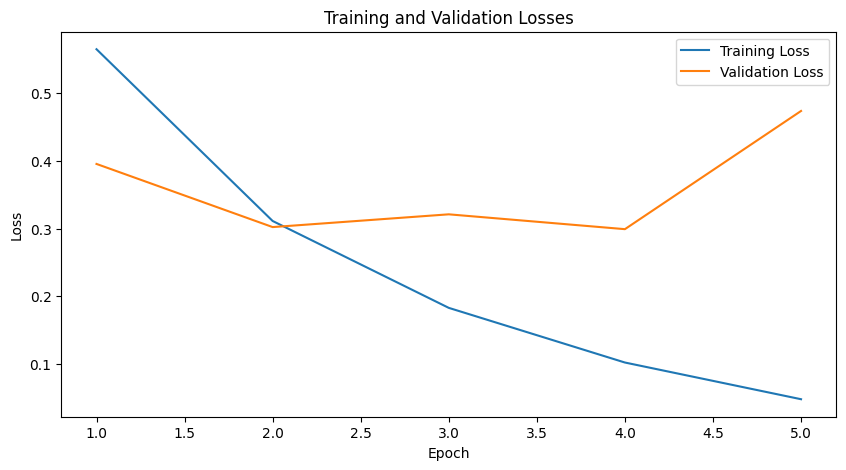

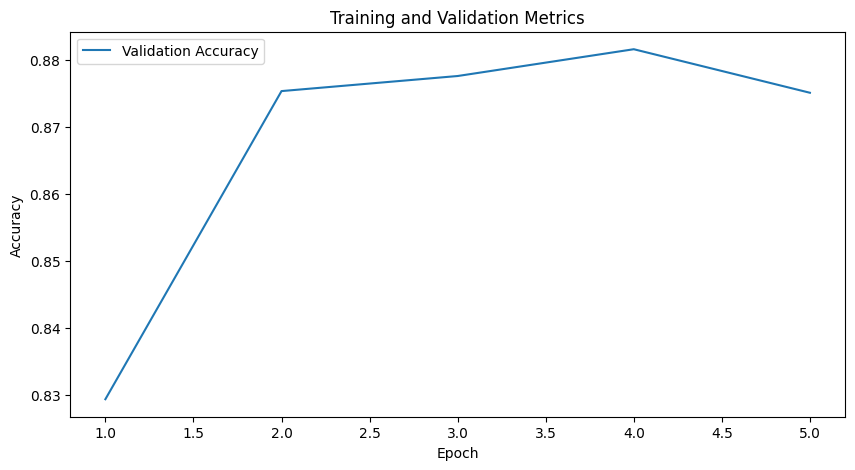

Evaluating Model: 100%|██████████| 628/628 [00:07<00:00, 87.15it/s]

Classification Accuracy on Test Set: 0.8663


In [9]:
!pip install datasets torchmetrics

import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from torch.utils.data import random_split

from sklearn.model_selection import train_test_split

from collections import defaultdict

from tqdm import tqdm


SEED = 1234
# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

# Extract features and labels from the dataset
features = imdb_dataset['train']['text']
labels = imdb_dataset['train']['label']

# Split the data into train and validation sets while maintaining label ratios
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)


def clean(text, tokenizer):
    text = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens
    
    
def get_word2idx(reviews):
    idx = 1
    word2idx = defaultdict(int)
    for sentence in tqdm(reviews, total=len(reviews), desc="Creating word2idx"):
        # Clean and tokenize the sentence
        words = clean(sentence, RegexpTokenizer(r'\w+'))
        
        # Check if sentence length is within the specified range
        if (len(words) <= 500) and (len(words) >= 100):
            for word in words:
                # Check if word is not already in word2idx
                if word not in word2idx:
                    word2idx[word] = idx
                    idx += 1

    return idx, word2idx

idx, word2idx = get_word2idx(train_reviews);
    
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean(review, tokenizer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]
    

test_reviews = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']
train_ds = IMDBDataset(train_reviews, train_labels, word2idx, minlen=100, maxlen=500)
val_ds = IMDBDataset(val_reviews, val_labels, word2idx, minlen=100, maxlen=500)
test_ds = IMDBDataset(test_reviews, test_labels, word2idx, minlen=100, maxlen=500)

# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
test_dataloader = DataLoader(test_ds, **params)
val_dataloader = DataLoader(val_ds, **params)


class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)  # Apply embedding
        lstm_output, _ = self.lstm(embedded)  # LSTM layer
        mean_output = torch.mean(lstm_output, dim=1)  # Take the mean of all time steps' outputs
        logits = self.fc(mean_output)  # Apply linear layer
        return logits
    
    
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2
vocab_size = len(word2idx)+1

# Create the model
model = LSTMModel(len(word2idx)+1, hidden_size, embedding_dim, num_classes).to(device)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary
print(model)


def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    val_accuracy = []  # List to store validation accuracy

    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training Epoch {}".format(epoch + 1)):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()  # Clear gradients
            output = model(input_batch)  # Forward pass
            loss = criterion(output, output_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            train_loss += loss.item() * input_batch.size(0)  # Accumulate training loss

        train_loss /= len(train_dataloader.dataset)  # Calculate average training loss
        train_losses.append(train_loss)  # Save training loss for this epoch

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation Epoch {}".format(epoch + 1)):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                output = model(input_batch)  # Forward pass
                loss = criterion(output, output_batch)  # Compute validation loss
                val_loss += loss.item() * input_batch.size(0)  # Accumulate validation loss

                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct_preds += (predicted == output_batch).sum().item()
                total_preds += output_batch.size(0)

        val_loss /= len(val_dataloader.dataset)  # Calculate average validation loss
        val_losses.append(val_loss)  # Save validation loss for this epoch

        accuracy = correct_preds / total_preds  # Calculate validation accuracy
        val_accuracy.append(accuracy)  # Save validation accuracy for this epoch

        # Log metrics
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model_state)

    return train_losses, val_losses, val_accuracy

#Calling model here
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, 5, device)


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(dataloader, total=len(dataloader), desc="Evaluating Model"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            output = model(input_batch)  # Forward pass
            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == output_batch).sum().item()
            total_preds += output_batch.size(0)
    
    accuracy = correct_preds / total_preds
    return accuracy

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, test_dataloader)

print(f"Classification Accuracy on Test Set: {test_accuracy:.4f}")

*The superior performance of LSTMs over traditional RNNs in sequential data tasks stems from their ability to handle long-term dependencies, incorporate gated mechanisms for selective processing, model complex patterns, and mitigate gradient-related issues. These advantages make LSTMs well-suited for a wide range of sequential data applications and contribute to the observed increase in accuracy in comparison to RNNs on the same parameters.*